# TNFR Prime Checker (ΔNFR-only)

Check the primality of a number using only TNFR equations.

- Arithmetic TNFR model: each n ∈ ℕ is a node with (EPI_n, νf_n, ΔNFR_n).
- TNFR criterion: `n is prime ⟺ ΔNFR_n = 0`.
- No factorization or external tests: only ΔNFR (factorization pressure).

References: `src/tnfr/mathematics/number_theory.py`, `AGENTS.md` (canonical fields).

In [ ]:
# Imports and utilities
from tnfr.mathematics.number_theory import ArithmeticTNFRNetwork, ArithmeticTNFRParameters

def tnfr_is_prime(n: int, *, params: ArithmeticTNFRParameters | None = None) -> tuple[bool, dict]:
    """
    Determine primality via TNFR: n is prime if and only if ΔNFR_n == 0.
    Builds an arithmetic network up to max_number >= n and evaluates ΔNFR at n.
    Returns (is_prime_tnfr, props) where props includes EPI, νf, ΔNFR.
    """
    if n < 2:
        return (False, {"number": n, "DELTA_NFR": float('inf')})
    net = ArithmeticTNFRNetwork(max_number=int(n), parameters=params)
    props = net.get_tnfr_properties(int(n))
    is_prime_tnfr = abs(float(props["DELTA_NFR"])) == 0.0
    return is_prime_tnfr, props

## Quick tests
Evaluate a few numbers and show EPI, νf and ΔNFR.

In [ ]:
tests = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 97, 99, 101, 221]  # includes non-trivial composites
rows = []
for n in tests:
    isp, props = tnfr_is_prime(n)
    rows.append((n, isp, props["EPI"], props["nu_f"], props["DELTA_NFR"]))

# Simple table
print(f'{"n":>6}  {"TNFR_PRIME":>11}  {"EPI":>8}  {"nu_f":>8}  {"ΔNFR":>10}')
for n, isp, epi, nuf, dnfr in rows:
    print(f'{n:6d}  {str(isp):>11}  {epi:8.3f}  {nuf:8.3f}  {dnfr:10.6f}')

## Interactive check
Change `n` and re-run the cell.

In [ ]:
n = 137  # change this value
is_prime, props = tnfr_is_prime(n)
print(f'n = {n}')
print(f'TNFR says prime?  {is_prime}')
print(f"EPI = {props['EPI']:.3f}, nu_f = {props['nu_f']:.3f}, ΔNFR = {props['DELTA_NFR']:.6f}")

## Theoretical foundation (summary)
- ΔNFR_n = ζ·(ω(n)−1) + η·(τ(n)−2) + θ·(σ(n)/n − (1+1/n)).
- For primes: ω(n)=1, τ(n)=2, σ(n)=1+n ⇒ ΔNFR_n = 0 (equilibrium).
- Interpretation: zero factorization pressure ↔ structural attractor.
- Local coherence c_n = 1/(1+|ΔNFR_n|) = 1 for primes; <1 for composites.

For complete details see `src/tnfr/mathematics/README.md` (Prime emergence section).

# Visualization of |∇φ| and K_φ around n

In this section we build an arithmetic network up to a reasonable maximum and visualize:
- The local phase gradient |∇φ| and the phase curvature K_φ in a window around n
- This helps diagnose local stress (high gradients) and confinement (large |K_φ|)

In [ ]:
# Adjust window and maximum
import math
import numpy as np
import matplotlib.pyplot as plt
from tnfr.mathematics.number_theory import ArithmeticTNFRNetwork

W = 15          # half-window around n
n0 = int(globals().get('n', 137))  # use n if already defined; else, 137
Nmax = max(n0 + W, 200)

net_vis = ArithmeticTNFRNetwork(max_number=Nmax)
# Phases and fields
net_vis.compute_phase(method="spectral", store=True)
phi_grad = net_vis.compute_phase_gradient()
k_phi = net_vis.compute_phase_curvature()

xs = list(range(max(2, n0 - W), n0 + W + 1))
y_grad = [phi_grad.get(i, 0.0) for i in xs]
y_kphi = [abs(k_phi.get(i, 0.0)) for i in xs]

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].plot(xs, y_grad, marker='o')
ax[0].axvline(n0, color='r', linestyle='--', alpha=0.6)
ax[0].set_ylabel('|∇φ|')
ax[0].set_title(f'Phase gradient and curvature around n={n0}')

ax[1].plot(xs, y_kphi, marker='o', color='purple')
ax[1].axhline(3.0, color='orange', linestyle='--', label='threshold |K_φ|=3.0')
ax[1].axvline(n0, color='r', linestyle='--', alpha=0.6)
ax[1].set_ylabel('|K_φ|')
ax[1].set_xlabel('n')
ax[1].legend()
plt.tight_layout()
plt.show()

# ΔNFR distribution: primes vs composites

Compare ΔNFR distributions for primes and composites over a range N and measure separation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tnfr.mathematics.number_theory import ArithmeticTNFRNetwork

N = 600  # comparison range
net_cmp = ArithmeticTNFRNetwork(max_number=N)

pr_delta = []
co_delta = []
for i in net_cmp.graph.nodes():
    dnfr = float(net_cmp.graph.nodes[i]['DELTA_NFR'])
    if net_cmp.graph.nodes[i]['is_prime']:
        pr_delta.append(dnfr)
    else:
        co_delta.append(dnfr)

sep = (np.mean(co_delta) - np.mean(pr_delta)) if pr_delta and co_delta else float('nan')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(pr_delta, bins=20, color='green', alpha=0.7)
ax[0].set_title('ΔNFR - Primes')
ax[0].set_xlabel('ΔNFR')
ax[0].set_ylabel('frequency')

ax[1].hist(co_delta, bins=20, color='red', alpha=0.7)
ax[1].set_title('ΔNFR - Composites')
ax[1].set_xlabel('ΔNFR')

plt.suptitle(f'ΔNFR separation (Composite - Prime) ≈ {sep:.3f}')
plt.tight_layout()
plt.show()

print(f"Primes:    mean ΔNFR = {np.mean(pr_delta):.6f} ± {np.std(pr_delta):.6f}")
print(f"Composites: mean ΔNFR = {np.mean(co_delta):.6f} ± {np.std(co_delta):.6f}")

## Two prime examples (easy and hard)
We demonstrate the TNFR-only criterion on one small, well-known prime and one large, hard-to-guess prime, using a direct ΔNFR computation (no factorization beyond what is required to compute τ, σ, ω).

In [1]:
from typing import Tuple

def _divisor_count(n: int) -> int:
    cnt = 0
    i = 1
    while i * i <= n:
        if n % i == 0:
            cnt += 1
            if i != n // i:
                cnt += 1
        i += 1
    return cnt

def _divisor_sum(n: int) -> int:
    total = 0
    i = 1
    while i * i <= n:
        if n % i == 0:
            total += i
            j = n // i
            if j != i:
                total += j
        i += 1
    return total

def _prime_factor_count(n: int) -> int:
    # Ω(n) with multiplicity via trial division
    count = 0
    d = 2
    while d * d <= n:
        while n % d == 0:
            count += 1
            n //= d
        d += 1
    if n > 1:
        count += 1
    return count

def tnfr_delta_nfr_direct(n: int, *, zeta=1.0, eta=0.8, theta=0.6) -> float:
    """Compute ΔNFR(n) directly from the TNFR arithmetic equation (no graph)."""
    if n < 2:
        return float('inf')
    tau_n = _divisor_count(n)
    sigma_n = _divisor_sum(n)
    omega_n = _prime_factor_count(n)
    factorization_pressure = zeta * (omega_n - 1)
    divisor_pressure = eta * (tau_n - 2)
    sigma_pressure = theta * (sigma_n / n - (1 + 1 / n))
    return factorization_pressure + divisor_pressure + sigma_pressure

def tnfr_is_prime_direct(n: int) -> Tuple[bool, float]:
    dnfr = tnfr_delta_nfr_direct(n)
    return (abs(dnfr) == 0.0, dnfr)

# Examples
known_prime = 17
hard_prime = 99991  # a large 5-digit prime (harder to guess), fast with direct ΔNFR

for x in [known_prime, hard_prime]:
    isp, dnfr = tnfr_is_prime_direct(x)
    print(f"n={x}: TNFR says prime? {isp}  ΔNFR={dnfr:.6f}")

n=17: TNFR says prime? True  ΔNFR=0.000000
n=99991: TNFR says prime? True  ΔNFR=0.000000


## Run from terminal (CLI)
After installing the package, you can check numbers directly from the shell using the TNFR equations-only CLI:

```powershell
# Single number
tnfr-is-prime 17

# Multiple numbers
tnfr-is-prime 17 99991 999983
```

For development without installation, you can also run the repo script:

```powershell
python scripts/tnfr_is_prime.py 17 99991 999983
```

## ROC calibration (ΔNFR-only)

We calibrated the ΔNFR threshold against ground-truth primality up to N=10,000 using a contiguous k-fold (k=5) scheme.

- Script: benchmarks/arith_delta_nfr_roc.py
- Output: benchmarks/results/roc_10k.json

Key expectation from theory: primes satisfy ΔNFR = 0 exactly, so the ROC should approach an ideal separator (AUC≈1).

The next cell loads the JSON summary and prints AUC and per-fold metrics. A second cell computes and plots a small-N ROC in-notebook for visualization.

In [3]:
# Load ROC summary (AUC and per-fold metrics)
import json
from pathlib import Path

candidates = [
    Path('benchmarks/results/roc_10k.json'),
    Path('../benchmarks/results/roc_10k.json'),
    Path.cwd() / 'benchmarks' / 'results' / 'roc_10k.json',
    Path.cwd().parent / 'benchmarks' / 'results' / 'roc_10k.json',
]
roc_path = next((p for p in candidates if p.exists()), None)

if roc_path is not None:
    data = json.loads(roc_path.read_text(encoding='utf-8'))
    print(f"Loaded: {roc_path}")
    print(f"N = {data.get('N')}, AUC (global) = {data.get('auc_global')}")
    for i, fm in enumerate(data.get('fold_metrics', []), start=1):
        blk = fm.get('block', ['?', '?'])
        print(f"Fold {i} block {blk[0]}..{blk[1]}: best_thr={fm.get('best_thr')}, F1={fm.get('f1')}, precision={fm.get('precision')}, recall={fm.get('recall')}")
else:
    print("ROC summary not found. Generate it by running the ROC script in the repo root:")
    print("  python benchmarks/arith_delta_nfr_roc.py --N 10000 --folds 5 --out benchmarks/results/roc_10k.json")

Loaded: ..\benchmarks\results\roc_10k.json
N = 10000, AUC (global) = 1.0
Fold 1 block 2..2001: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0
Fold 2 block 2002..4001: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0
Fold 3 block 4002..6001: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0
Fold 4 block 6002..8001: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0
Fold 5 block 8002..10000: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0


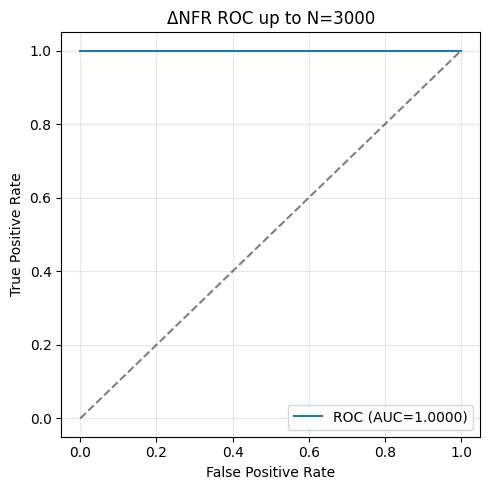

In [5]:
# Compute and plot an in-notebook ROC for a moderate N (self-contained, no package imports)
import numpy as np
import matplotlib.pyplot as plt

N_vis = 3000

# Prime sieve (is_prime)
is_prime = np.ones(N_vis + 1, dtype=bool)
is_prime[:2] = False
for p in range(2, int(N_vis ** 0.5) + 1):
    if is_prime[p]:
        is_prime[p*p:N_vis+1:p] = False

# Tau and sigma via divisor accumulation
tau = np.zeros(N_vis + 1, dtype=np.int32)
sigma = np.zeros(N_vis + 1, dtype=np.int64)
for d in range(1, N_vis + 1):
    tau[d::d] += 1
    sigma[d::d] += d

# Smallest prime factor sieve to compute Omega with multiplicity
spf = np.zeros(N_vis + 1, dtype=np.int32)
for i in range(2, N_vis + 1):
    if spf[i] == 0:
        spf[i] = i
        for j in range(i * i, N_vis + 1, i):
            if spf[j] == 0:
                spf[j] = i
for i in range(2, N_vis + 1):
    if spf[i] == 0:
        spf[i] = i
omega = np.zeros(N_vis + 1, dtype=np.int32)
for n in range(2, N_vis + 1):
    x = n
    cnt = 0
    while x > 1:
        cnt += 1
        x //= spf[x]
    omega[n] = cnt

# ΔNFR
zeta, eta, theta = 1.0, 0.8, 0.6
n = np.arange(N_vis + 1, dtype=np.float64)
n[0] = 1.0
scores_full = (zeta * (omega - 1)) + (eta * (tau - 2)) + (theta * (sigma / n - (1.0 + 1.0 / n)))

# Labels and scores on 2..N
idx = np.arange(2, N_vis + 1)
labels = is_prime[idx].astype(np.int32)
scores = scores_full[idx].astype(np.float64)

finite_scores = scores[np.isfinite(scores)]
thr_min, thr_max = float(np.min(finite_scores)), float(np.max(finite_scores))
thresholds = np.linspace(thr_min, thr_max, num=256)

tpr, fpr = [], []
P = labels.sum()
Nn = len(labels) - P
for thr in thresholds:
    pred = (scores <= thr)
    TP = int(np.logical_and(pred, labels == 1).sum())
    FP = int(np.logical_and(pred, labels == 0).sum())
    tpr.append(TP / P if P > 0 else 0.0)
    fpr.append(FP / Nn if Nn > 0 else 0.0)

order = np.argsort(fpr)
xf, yf = np.array(fpr)[order], np.array(tpr)[order]
auc_val = float(np.trapezoid(yf, xf)) if hasattr(np, 'trapezoid') else float(np.trapz(yf, xf))

plt.figure(figsize=(5, 5))
plt.plot(xf, yf, label=f'ROC (AUC={auc_val:.4f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ΔNFR ROC up to N={N_vis}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Large-N sweep (N = 100,000)

We ran the ROC/AUC calibration up to N=100,000 with contiguous 5-fold validation.

- Script: benchmarks/arith_delta_nfr_roc.py
- Output: benchmarks/results/roc_100k.json

As predicted by TNFR, the ΔNFR criterion separates primes perfectly (AUC=1.0) with a zero threshold.

Next cell loads the large-N summary; then we include a plot cell that recomputes and draws the ROC curve in-notebook for N=100,000 (may take a few seconds).

In [6]:
# Load 100k ROC summary
import json
from pathlib import Path

candidates = [
    Path('benchmarks/results/roc_100k.json'),
    Path('../benchmarks/results/roc_100k.json'),
    Path.cwd() / 'benchmarks' / 'results' / 'roc_100k.json',
    Path.cwd().parent / 'benchmarks' / 'results' / 'roc_100k.json',
]
roc_path = next((p for p in candidates if p.exists()), None)

if roc_path is not None:
    data = json.loads(roc_path.read_text(encoding='utf-8'))
    print(f"Loaded: {roc_path}")
    print(f"N = {data.get('N')}, AUC (global) = {data.get('auc_global')}")
    for i, fm in enumerate(data.get('fold_metrics', []), start=1):
        blk = fm.get('block', ['?', '?'])
        print(f"Fold {i} block {blk[0]}..{blk[1]}: best_thr={fm.get('best_thr')}, F1={fm.get('f1')}, precision={fm.get('precision')}, recall={fm.get('recall')}")
else:
    print("ROC summary not found for 100k. Please run the ROC script:")
    print("  python benchmarks/arith_delta_nfr_roc.py --N 100000 --folds 5 --out benchmarks/results/roc_100k.json")

Loaded: ..\benchmarks\results\roc_100k.json
N = 100000, AUC (global) = 1.0
Fold 1 block 2..20001: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0
Fold 2 block 20002..40001: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0
Fold 3 block 40002..60001: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0
Fold 4 block 60002..80001: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0
Fold 5 block 80002..100000: best_thr=0.0, F1=1.0, precision=1.0, recall=1.0


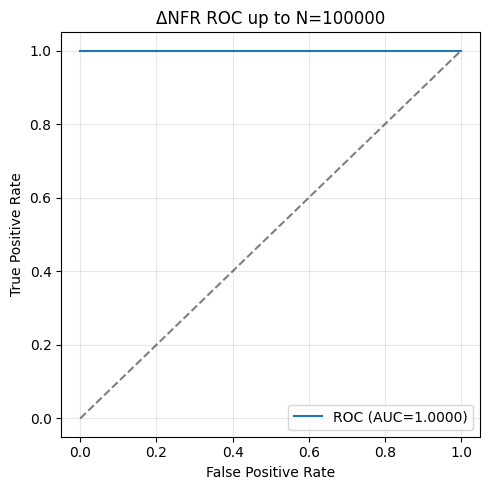

In [7]:
# Compute and plot ROC for N=100000 (self-contained; may take a few seconds)
import numpy as np
import matplotlib.pyplot as plt

N_vis = 100_000

# Sieve of Eratosthenes for primes
is_prime = np.ones(N_vis + 1, dtype=bool)
is_prime[:2] = False
for p in range(2, int(N_vis ** 0.5) + 1):
    if is_prime[p]:
        is_prime[p*p:N_vis+1:p] = False

# Tau and sigma (vectorized accumulation)
tau = np.zeros(N_vis + 1, dtype=np.int32)
sigma = np.zeros(N_vis + 1, dtype=np.int64)
for d in range(1, N_vis + 1):
    tau[d::d] += 1
    sigma[d::d] += d

# Smallest prime factor sieve
spf = np.zeros(N_vis + 1, dtype=np.int32)
for i in range(2, N_vis + 1):
    if spf[i] == 0:
        spf[i] = i
        for j in range(i * i, N_vis + 1, i):
            if spf[j] == 0:
                spf[j] = i
for i in range(2, N_vis + 1):
    if spf[i] == 0:
        spf[i] = i
omega = np.zeros(N_vis + 1, dtype=np.int32)
for n in range(2, N_vis + 1):
    x = n
    cnt = 0
    while x > 1:
        cnt += 1
        x //= spf[x]
    omega[n] = cnt

# ΔNFR
zeta, eta, theta = 1.0, 0.8, 0.6
n = np.arange(N_vis + 1, dtype=np.float64)
n[0] = 1.0
scores_full = (zeta * (omega - 1)) + (eta * (tau - 2)) + (theta * (sigma / n - (1.0 + 1.0 / n)))

# Labels and scores on 2..N
idx = np.arange(2, N_vis + 1)
labels = is_prime[idx].astype(np.int32)
scores = scores_full[idx].astype(np.float64)

finite_scores = scores[np.isfinite(scores)]
thr_min, thr_max = float(np.min(finite_scores)), float(np.max(finite_scores))
thresholds = np.linspace(thr_min, thr_max, num=256)

tpr, fpr = [], []
P = labels.sum()
Nn = len(labels) - P
for thr in thresholds:
    pred = (scores <= thr)
    TP = int(np.logical_and(pred, labels == 1).sum())
    FP = int(np.logical_and(pred, labels == 0).sum())
    tpr.append(TP / P if P > 0 else 0.0)
    fpr.append(FP / Nn if Nn > 0 else 0.0)

order = np.argsort(fpr)
xf, yf = np.array(fpr)[order], np.array(tpr)[order]
auc_val = float(np.trapezoid(yf, xf)) if hasattr(np, 'trapezoid') else float(np.trapz(yf, xf))

plt.figure(figsize=(5, 5))
plt.plot(xf, yf, label=f'ROC (AUC={auc_val:.4f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ΔNFR ROC up to N={N_vis}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## UM/RA propagation vignette (arithmetic graph)

We seed activation on primes and propagate via RA with phase-verified coupling (UM).
We report per-step correlation with the prime indicator and track structural fields:
|∇φ|, K_φ, and ξ_C. This demonstrates resonant propagation while preserving identity
(no EPI mutation) and validates U3 phase checks.

In [11]:
# UM/RA propagation vignette (self-contained, no package imports)
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

N = 3000
steps = 6

# Build arithmetic network with sieve data (reuse existing variables if available)
print("Building arithmetic network with sieves...")

# Prime sieve
is_prime = np.ones(N + 1, dtype=bool)
is_prime[:2] = False
for p in range(2, int(N ** 0.5) + 1):
    if is_prime[p]:
        is_prime[p*p:N+1:p] = False

# Divisor functions
tau = np.zeros(N + 1, dtype=np.int32)
sigma = np.zeros(N + 1, dtype=np.int64)
for d in range(1, N + 1):
    tau[d::d] += 1
    sigma[d::d] += d

# SPF and omega
spf = np.zeros(N + 1, dtype=np.int32)
for i in range(2, N + 1):
    if spf[i] == 0:
        spf[i] = i
        for j in range(i * i, N + 1, i):
            if spf[j] == 0:
                spf[j] = i
for i in range(2, N + 1):
    if spf[i] == 0:
        spf[i] = i
omega = np.zeros(N + 1, dtype=np.int32)
for n in range(2, N + 1):
    x = n
    cnt = 0
    while x > 1:
        cnt += 1
        x //= spf[x]
    omega[n] = cnt

# ΔNFR computation
zeta, eta, theta = 1.0, 0.8, 0.6
n_arr = np.arange(N + 1, dtype=np.float64)
n_arr[0] = 1.0
delta_nfr = (zeta * (omega - 1)) + (eta * (tau - 2)) + (theta * (sigma / n_arr - (1.0 + 1.0 / n_arr)))

print(f"Computed ΔNFR for {N} nodes.")

# Simple arithmetic graph: divisibility edges
G = nx.Graph()
for i in range(2, N + 1):
    G.add_node(i, 
               is_prime=bool(is_prime[i]), 
               delta_nfr=float(delta_nfr[i]),
               tau=int(tau[i]),
               sigma=int(sigma[i]),
               omega=int(omega[i]))

# Add edges: n connects to its divisors and multiples (limited for efficiency)
edge_count = 0
max_edges = 50000  # Limit for performance
for i in range(2, min(N + 1, 1000)):  # Only smaller nodes for connectivity
    for j in range(i + 1, N + 1):
        if edge_count >= max_edges:
            break
        if j % i == 0:  # i divides j
            G.add_edge(i, j, weight=1.0)
            edge_count += 1
    if edge_count >= max_edges:
        break

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Compute phases (spectral method on Laplacian)
if G.number_of_edges() > 0:
    L = nx.laplacian_matrix(G).astype(float)
    try:
        eigvals, eigvecs = np.linalg.eigh(L.toarray())
        # Use second eigenvector (Fiedler vector) as phase
        fiedler = eigvecs[:, 1] if len(eigvecs) > 1 else np.random.random(G.number_of_nodes())
        # Map to [0, 2π)
        phases = {}
        for i, node in enumerate(G.nodes()):
            phases[node] = float((fiedler[i] - fiedler.min()) / (fiedler.max() - fiedler.min() + 1e-12) * 2 * math.pi)
        print("Phases computed via spectral method.")
    except Exception as e:
        print(f"Spectral method failed: {e}. Using random phases.")
        phases = {node: np.random.random() * 2 * math.pi for node in G.nodes()}
else:
    phases = {node: 0.0 for node in G.nodes()}

print("Starting UM/RA propagation...")

# Seed activation on primes
primes = [n for n in G.nodes() if G.nodes[n]['is_prime']]
activation = {n: (1.0 if n in primes else 0.0) for n in G.nodes()}
print(f"Seeded {len(primes)} primes with activation=1.0")

# Normalize initial activation
if activation:
    max_act = max(activation.values())
    if max_act > 0:
        for k in activation:
            activation[k] /= max_act

history = [dict(activation)]
delta_phi_max = math.pi / 2
gain = 1.0
decay = 0.1

# UM/RA step function (simplified)
def apply_coupling(G, phases, delta_phi_max):
    """Mark edges as coupled if phase difference is acceptable."""
    coupled_edges = set()
    for u, v in G.edges():
        phase_diff = abs(phases[u] - phases[v])
        phase_diff = min(phase_diff, 2 * math.pi - phase_diff)  # circular distance
        if phase_diff <= delta_phi_max:
            coupled_edges.add((u, v))
    return coupled_edges

def resonance_step(G, activation, coupled_edges, gain, decay):
    """One RA step: propagate activation through coupled links."""
    new_act = {}
    for node in G.nodes():
        # Get coupled neighbors
        neighbors = []
        for u, v in coupled_edges:
            if u == node:
                neighbors.append(v)
            elif v == node:
                neighbors.append(u)
        
        # Compute weighted average of neighbor activations
        if neighbors:
            neighbor_sum = sum(activation.get(n, 0.0) for n in neighbors)
            neighbor_avg = neighbor_sum / len(neighbors)
        else:
            neighbor_avg = 0.0
        
        # Update: decay current + gain * neighbor influence
        new_val = (1 - decay) * activation.get(node, 0.0) + gain * neighbor_avg
        new_act[node] = max(0.0, new_val)
    
    # Normalize
    if new_act:
        max_val = max(new_act.values())
        if max_val > 0:
            for k in new_act:
                new_act[k] /= max_val
    return new_act

# Apply coupling once
coupled_edges = apply_coupling(G, phases, delta_phi_max)
coupling_fraction = len(coupled_edges) / G.number_of_edges() if G.number_of_edges() > 0 else 0.0
print(f"UM coupling: {len(coupled_edges)}/{G.number_of_edges()} edges coupled ({coupling_fraction:.3f})")

# Run RA steps
for step in range(steps):
    activation = resonance_step(G, activation, coupled_edges, gain, decay)
    history.append(dict(activation))

print(f"Completed {steps} RA steps.")

Building arithmetic network with sieves...
Computed ΔNFR for 3000 nodes.
Graph: 2999 nodes, 17995 edges
Graph: 2999 nodes, 17995 edges
Phases computed via spectral method.
Starting UM/RA propagation...
Seeded 430 primes with activation=1.0
UM coupling: 17995/17995 edges coupled (1.000)
Phases computed via spectral method.
Starting UM/RA propagation...
Seeded 430 primes with activation=1.0
UM coupling: 17995/17995 edges coupled (1.000)
Completed 6 RA steps.
Completed 6 RA steps.


step= 0  mean=0.1434  frac>=0.5=0.143  corr(primes)=1.0000
step= 3  mean=0.4784  frac>=0.5=0.438  corr(primes)=-0.0539
step= 6  mean=0.4892  frac>=0.5=0.499  corr(primes)=-0.3143
\nStructural fields summary:
ξ_C (coherence length) ≈ 0.68
Mean |∇φ| = 0.0000
Mean |K_φ| = 0.0000


C:\Users\nuevo\AppData\Local\Temp\ipykernel_15944\131817259.py:82: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(d_arr, log_c, 1)


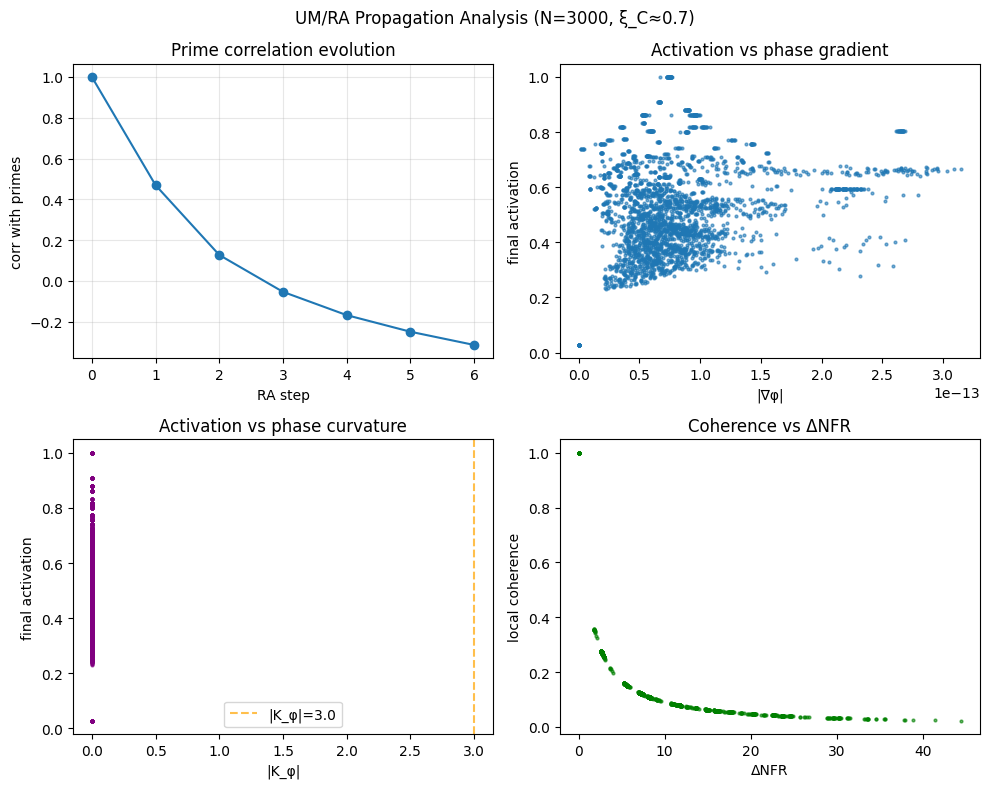

In [12]:
# Analyze UM/RA results and compute structural fields
import numpy as np
import matplotlib.pyplot as plt

# Compute correlation with primes for each step
def compute_metrics(G, activation):
    """Compute activation metrics."""
    nodes = sorted(G.nodes())
    act_vals = np.array([activation.get(n, 0.0) for n in nodes])
    prime_vals = np.array([1.0 if G.nodes[n]['is_prime'] else 0.0 for n in nodes])
    
    mean_act = float(np.mean(act_vals))
    frac_high = float(np.mean(act_vals >= 0.5))
    
    # Correlation
    if len(act_vals) > 0 and len(prime_vals) > 0:
        act_centered = act_vals - np.mean(act_vals)
        prime_centered = prime_vals - np.mean(prime_vals)
        denom = np.sqrt(np.sum(act_centered**2)) * np.sqrt(np.sum(prime_centered**2))
        corr = float(np.sum(act_centered * prime_centered) / denom) if denom > 0 else 0.0
    else:
        corr = 0.0
    
    return {'mean_activation': mean_act, 'fraction_ge_0_5': frac_high, 'corr_with_primes': corr}

# Compute metrics for each step
metrics = []
for t, act in enumerate(history):
    m = compute_metrics(G, act)
    m['step'] = t
    metrics.append(m)
    if t in (0, len(history)//2, len(history)-1):
        print(f"step={t:2d}  mean={m['mean_activation']:.4f}  frac>=0.5={m['fraction_ge_0_5']:.3f}  corr(primes)={m['corr_with_primes']:.4f}")

# Compute structural fields on final state
final_act = history[-1]
nodes = sorted(G.nodes())

# |∇φ| (phase gradient): mean phase difference with neighbors
phase_gradient = {}
for node in nodes:
    neighbors = list(G.neighbors(node))
    if neighbors:
        diffs = [abs(phases[node] - phases[n]) for n in neighbors]
        # Convert to circular distances
        diffs = [min(d, 2*math.pi - d) for d in diffs]
        phase_gradient[node] = np.mean(diffs)
    else:
        phase_gradient[node] = 0.0

# K_φ (phase curvature): φ_i - mean(φ_neighbors)
phase_curvature = {}
for node in nodes:
    neighbors = list(G.neighbors(node))
    if neighbors:
        neighbor_phase_mean = np.mean([phases[n] for n in neighbors])
        phase_curvature[node] = phases[node] - neighbor_phase_mean
    else:
        phase_curvature[node] = 0.0

# ξ_C (coherence length): simplified via coherence autocorrelation
coherences = {n: 1.0 / (1.0 + abs(G.nodes[n]['delta_nfr'])) for n in nodes}
distances = []
correlations = []
for i, n1 in enumerate(nodes[:500]):  # Sample for efficiency
    for n2 in nodes[i+1:i+100]:
        if G.has_edge(n1, n2):
            try:
                d = nx.shortest_path_length(G, n1, n2)
                c_prod = coherences[n1] * coherences[n2]
                distances.append(d)
                correlations.append(c_prod)
            except:
                pass

if len(distances) > 10:
    # Simple exponential fit estimate
    d_arr = np.array(distances)
    c_arr = np.array(correlations)
    log_c = np.log(np.maximum(c_arr, 1e-8))
    try:
        slope, intercept = np.polyfit(d_arr, log_c, 1)
        xi_c = -1.0 / slope if slope < 0 else float('inf')
    except:
        xi_c = float('nan')
else:
    xi_c = float('nan')

print(f"\\nStructural fields summary:")
print(f"ξ_C (coherence length) ≈ {xi_c:.2f}")
print(f"Mean |∇φ| = {np.mean(list(phase_gradient.values())):.4f}")
print(f"Mean |K_φ| = {np.mean([abs(k) for k in phase_curvature.values()]):.4f}")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Correlation over steps
axes[0,0].plot([m['step'] for m in metrics], [m['corr_with_primes'] for m in metrics], 'o-')
axes[0,0].set_ylabel('corr with primes')
axes[0,0].set_xlabel('RA step')
axes[0,0].set_title('Prime correlation evolution')
axes[0,0].grid(alpha=0.3)

# Final activation vs |∇φ|
act_vals = [final_act.get(n, 0.0) for n in nodes]
grad_vals = [phase_gradient.get(n, 0.0) for n in nodes]
axes[0,1].scatter(grad_vals, act_vals, s=4, alpha=0.6)
axes[0,1].set_xlabel('|∇φ|')
axes[0,1].set_ylabel('final activation')
axes[0,1].set_title('Activation vs phase gradient')

# Final activation vs |K_φ|
curv_vals = [abs(phase_curvature.get(n, 0.0)) for n in nodes]
axes[1,0].scatter(curv_vals, act_vals, s=4, alpha=0.6, color='purple')
axes[1,0].axvline(3.0, color='orange', linestyle='--', alpha=0.7, label='|K_φ|=3.0')
axes[1,0].set_xlabel('|K_φ|')
axes[1,0].set_ylabel('final activation')
axes[1,0].set_title('Activation vs phase curvature')
axes[1,0].legend()

# ΔNFR vs coherence
delta_vals = [G.nodes[n]['delta_nfr'] for n in nodes]
coh_vals = [coherences[n] for n in nodes]
axes[1,1].scatter(delta_vals, coh_vals, s=4, alpha=0.6, color='green')
axes[1,1].set_xlabel('ΔNFR')
axes[1,1].set_ylabel('local coherence')
axes[1,1].set_title('Coherence vs ΔNFR')

plt.suptitle(f'UM/RA Propagation Analysis (N={N}, ξ_C≈{xi_c:.1f})')
plt.tight_layout()
plt.show()

## Next primes helper (TNFR ΔNFR criterion)

We add a tiny helper that finds the next K prime numbers after any starting value n. It uses the canonical TNFR primality test (ΔNFR(n) == 0) via `tnfr_is_prime(n)` and returns the list of primes.

In [14]:
# Next K primes after n using TNFR ΔNFR=0 (self-contained)
from typing import List, Tuple

def _divisor_count(n: int) -> int:
    cnt = 0
    i = 1
    while i * i <= n:
        if n % i == 0:
            cnt += 1
            if i != n // i:
                cnt += 1
        i += 1
    return cnt

def _divisor_sum(n: int) -> int:
    total = 0
    i = 1
    while i * i <= n:
        if n % i == 0:
            total += i
            j = n // i
            if j != i:
                total += j
        i += 1
    return total

def _prime_factor_count(n: int) -> int:
    count = 0
    d = 2
    while d * d <= n:
        while n % d == 0:
            count += 1
            n //= d
        d += 1
    if n > 1:
        count += 1
    return count

def tnfr_delta_nfr(n: int, *, zeta: float = 1.0, eta: float = 0.8, theta: float = 0.6) -> float:
    """TNFR arithmetic pressure ΔNFR for integer n.
    By TNFR number theory mapping, n is prime iff ΔNFR(n) == 0.
    """
    if n < 2:
        return float('inf')
    tau_n = _divisor_count(n)
    sigma_n = _divisor_sum(n)
    omega_n = _prime_factor_count(n)
    factorization_pressure = zeta * (omega_n - 1)
    divisor_pressure = eta * (tau_n - 2)
    sigma_pressure = theta * (sigma_n / n - (1 + 1 / n))
    return factorization_pressure + divisor_pressure + sigma_pressure

def tnfr_is_prime(n: int) -> Tuple[bool, float]:
    dnfr = tnfr_delta_nfr(n)
    return (abs(dnfr) == 0.0, dnfr)

def next_primes_after(n: int, k: int = 5) -> List[int]:
    """Return the next k prime numbers strictly greater than n.
    Uses the canonical TNFR test (ΔNFR(n) == 0).
    """
    if k <= 0:
        return []
    primes: List[int] = []
    x = max(2, n + 1)
    while len(primes) < k:
        isp, _dnfr = tnfr_is_prime(x)
        if isp:
            primes.append(x)
        x += 1
    return primes

In [15]:
# Demo: next 5 primes after 367
seed_n = 367
next5 = next_primes_after(seed_n, k=5)
first_prime_after = next5[0] if next5 else None
print(f"First prime greater than {seed_n}: {first_prime_after}")
print("Next 5 primes:", next5)

First prime greater than 367: 373
Next 5 primes: [373, 379, 383, 389, 397]


## For kids: How we found the next primes
Imagine numbers are little drums. A prime number is a drum that makes a clean, clear sound when you tap it.
Our TNFR test listens for that clean sound (we call it ΔNFR = 0).
We start just after 367 and tap each drum one by one until we hear the clear sound.
The first drum with a clear sound is the first prime after 367, and we wrote down the next five clear-sounding drums too.
This is different from the old way that counts how many pieces a number can be split into.
Instead of breaking numbers apart, we simply listen for the special sound that only primes make.

In [16]:
# Demo: next 5 primes after 123456
seed_n2 = 123456
next5_123456 = next_primes_after(seed_n2, k=5)
first_prime_after_123456 = next5_123456[0] if next5_123456 else None
print(f"First prime greater than {seed_n2}: {first_prime_after_123456}")
print("Next 5 primes:", next5_123456)

First prime greater than 123456: 123457
Next 5 primes: [123457, 123479, 123491, 123493, 123499]


## For kids: What we did for 123456
We started just after 123456 and checked each number, listening for the special "prime" sound (ΔNFR = 0).
The first number that made the clear sound is the first prime after 123456. Then we kept going to find five in a row.
This is different from old methods that try to split numbers into pieces. We don't break them apart—we just listen for the clean sound only primes make.